In [ ]:
%reload_ext autoreload

In [ ]:
%matplotlib inline

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import dolphindb
sess = dolphindb.session()
sess.connect("localhost", 8868, "admin", "123456")

In [ ]:
print('DolphinDB available tables:')
sess.run('getClusterDFSTables()')

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [7]:
twse = pd.read_msgpack('/data/dataset/twse.msgpack')
twse.head()

/home/cyyen/miniconda3/envs/stock_path_tracker/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


,open,high,low,close,order_buy,order_sell,volume
date,,,,,,,
2005-07-11,6255.40,6305.61,6249.41,6298.86,88271.0,98780.0,93877.0
2005-07-12,6337.50,6365.76,6337.50,6358.81,86565.0,111912.0,101703.0
2005-07-13,6360.60,6406.99,6352.21,6377.09,80802.0,120531.0,106134.0
2005-07-14,6403.08,6427.32,6375.75,6418.35,92496.0,114781.0,106806.0
2005-07-15,6428.44,6454.33,6410.59,6410.59,88827.0,124306.0,106727.0


# Parameters

In [8]:
d_start, d_end = '2012-11-22', '2020-04-15' 
max_delta_cell = 2
max_d2m = 13

## quantization
- range: 2012-11-22 to 2020-04-15 (nrow: 1,804, after the launch of weekly option)
- 50 / cell, floor
- day-to-maturity

In [9]:
df = twse[d_start:][['close']].copy()

In [10]:
df['prc_qtz'] = df.close // 50 * 50
df['delta'] = df.prc_qtz.diff()

In [11]:
settlements = pd.to_datetime(pd.read_csv('settlement_txf.csv').settlement).dt.date.tolist()
df['maturity'] = df.index.where(df.index.isin(settlements)).to_series().fillna(method='bfill').values
d2m = df.groupby('maturity').size().sort_index().tolist()
df['d2m'] = sum([list(reversed(range(d))) for d in d2m], []) + [np.nan] * (df.shape[0] - sum(d2m))
df = df[d_start: d_end ]

df.dropna(inplace=True)
df.sort_index(ascending=True, inplace=True)

In [12]:
# vis
df[['close', 'prc_qtz', 'delta', 'd2m']].info()
df[['close', 'prc_qtz', 'delta', 'd2m']].head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1803 entries, 2012-11-23 to 2020-04-15
Data columns (total 4 columns):
close      1803 non-null float64
prc_qtz    1803 non-null float64
delta      1803 non-null float64
d2m        1803 non-null float64
dtypes: float64(4)
memory usage: 70.4 KB


,close,prc_qtz,delta,d2m
date,,,,
2012-11-23,7326.01,7300.0,200.0,18.0
2012-11-26,7407.37,7400.0,100.0,17.0
2012-11-27,7430.20,7400.0,0.0,16.0
2012-11-28,7434.93,7400.0,0.0,15.0
2012-11-29,7503.55,7500.0,100.0,14.0
2012-11-30,7580.17,7550.0,50.0,13.0
2012-12-03,7599.91,7550.0,0.0,12.0
2012-12-04,7600.98,7600.0,50.0,11.0
2012-12-05,7649.05,7600.0,0.0,10.0


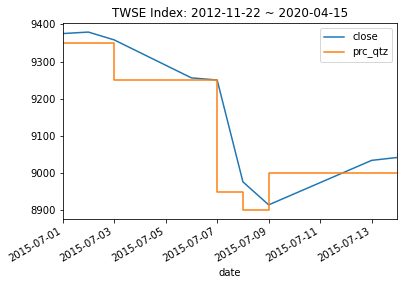

In [13]:
# vis
df_plot = df['2015-07-01': '2015-07-14' ]
ax = df_plot[['close']].plot(title=f'TWSE Index: {d_start} ~ {d_end}')
df_plot[['prc_qtz']].plot(drawstyle='steps', ax=ax)

In [14]:
df.groupby('d2m').size().to_frame('exists')

,exists
d2m,
0.0,89
1.0,89
2.0,89
3.0,89
4.0,89
5.0,89
6.0,89
7.0,89
8.0,89


## check feasible shape of transition matrix

Text(0.5, 1.0, '#(cells)')

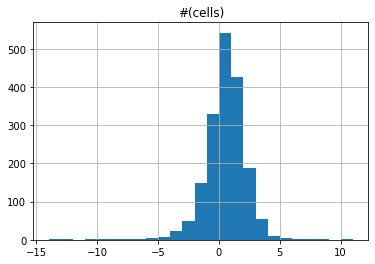

In [15]:
ax = df.delta.div(50).hist(bins=25)
ax.set_title('#(cells)')

In [16]:
df.delta.div(50).quantile([0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]).to_frame('delta').T

,0.00,0.10,0.25,0.50,0.75,0.90,1.00
delta,-14.0,-2.0,-1.0,0.0,1.0,2.0,11.0


# compute probabilty, conditional on day-to-maturity

In [17]:
# only consider complete samples [T-13, T]
df = df.query(f'd2m <= {max_d2m}').copy()

In [18]:
# winsorizing
df['delta_cell'] = df.delta // 50
df.loc[df.delta_cell >= max_delta_cell, 'delta_cell'] = max_delta_cell
df.loc[df.delta_cell <= - max_delta_cell , 'delta_cell'] = - max_delta_cell

In [19]:
m_prob = np.zeros((max_d2m+1, max_delta_cell*2+1))
for d2m, df_m in df.groupby('d2m'):
    m_prob[int(d2m), :] = df_m.groupby('delta_cell').size().div(df_m.shape[0])
df_prob = pd.DataFrame(m_prob, columns=['n1', 'n2', 'O', 'p1', 'p2'])
df_prob.index.name = 'day-to-maturity ( $\\tau$ )'
df_prob

,n1,n2,O,p1,p2
day-to-maturity ( $\tau$ ),,,,,
0,0.134831,0.179775,0.258427,0.303371,0.123596
1,0.101124,0.168539,0.280899,0.292135,0.157303
2,0.179775,0.202247,0.224719,0.280899,0.112360
3,0.123596,0.247191,0.292135,0.224719,0.112360
4,0.146067,0.168539,0.337079,0.191011,0.157303
5,0.146067,0.224719,0.224719,0.269663,0.134831
6,0.101124,0.202247,0.314607,0.292135,0.089888
7,0.134831,0.191011,0.247191,0.213483,0.213483
8,0.146067,0.202247,0.359551,0.191011,0.101124


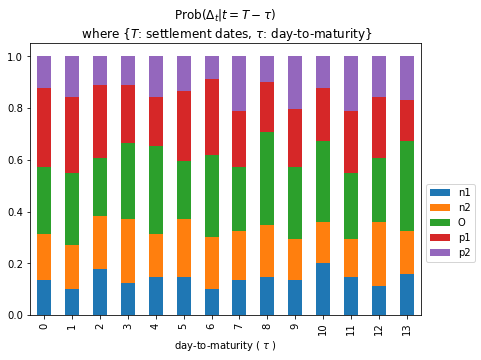

In [20]:
df_prob.plot.bar(stacked=True, figsize=(7, 5), title='Prob($\Delta_t$|$t=T-\\tau$) \n where {$T$: settlement dates, $\\tau$: day-to-maturity}').legend(bbox_to_anchor=(1.0, 0.5))

# list all possible realizations sequence
- currently only calcualte for $\tau \leq 9$, because of huge computing demand and memory

In [59]:
#
def gen_sequence(max_delta_cell):
    outcomes = [0] + list(range(1, max_delta_cell+1)) + list(range(-max_delta_cell, 0))  
    for i in outcomes: #0
        for j in outcomes: #1
            for k in outcomes: #2
                for l in outcomes: #3
                    for m in outcomes: #4
                        for n in outcomes: #5
                            for o in outcomes: #6
                                for p in outcomes: #7
                                    for q in outcomes: #8
                                        for r in outcomes: #9
                                            yield [i, j, k, l, m, n, o, p, q, r]

In [61]:
%%time
all_2s = []
for seq in gen_sequence(max_delta_cell):
    if sum(seq) == 2:#TODO: select range
        all_2s.append(seq)

CPU times: user 2.83 s, sys: 45.2 ms, total: 2.88 s
Wall time: 2.88 s


In [62]:
GB = 10**9
n_layer = 14
print(f'[{n_layer} days] used {sys.getsizeof(list(range(n_layer))) * 5**n_layer / GB:.2f} GB')

n_layer = 10
print(f'[{n_layer} days] used {sys.getsizeof(list(range(n_layer))) * 5**n_layer / GB:.2f} GB')

[14 days] used 1025.39 GB
[10 days] used 1.33 GB


In [52]:
df_real = pd.DataFrame(all_2s)
df_real['Lambda_0_8'] = df_real.sum(axis=1)
df_real.index.name = 'realization'
df_real.columns.name = 'day-to-maturity'
df_real.head(10)

day-to-maturity,0,1,2,3,4,5,6,7,8,Lambda_0_8
realization,,,,,,,,,,
0,0,0,0,0,0,0,0,0,2,2
1,0,0,0,0,0,0,0,1,1,2
2,0,0,0,0,0,0,0,2,0,2
3,0,0,0,0,0,0,1,0,1,2
4,0,0,0,0,0,0,1,1,0,2
5,0,0,0,0,0,0,1,2,-1,2
6,0,0,0,0,0,0,1,-1,2,2
7,0,0,0,0,0,0,2,0,0,2
8,0,0,0,0,0,0,2,1,-1,2
